# Forecast de Ventas 2026: Análisis por Tipo de Suscripción

**Objetivo:** Generar una proyección diaria de ventas (cantidad y/o ingresos) para el año 2026 basada en el histórico Agosto 2022 - Agosto 2025.

**Metodología:** Se utilizará el algoritmo **Prophet** (Meta), ideal para series de tiempo con fuerte estacionalidad y efectos de calendario.

**Datos de entrada:**
- Granularidad: Diaria
- Segmentación: `tipo_suscripcion`

In [181]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

# Configuración visual para los gráficos
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')
plt.rcParams['figure.figsize'] = (15, 6)

print("Librerías cargadas correctamente.")

Librerías cargadas correctamente.


In [182]:
# 1. Cargar el dataset
# Asegúrate de que el archivo esté en la misma carpeta o coloca la ruta completa
nombre_archivo = '../data/data_forecast_2025_silver/ingresos_membresia_3_dias_limpio.csv'  # <--- CAMBIA ESTO POR TU ARCHIVO REAL
df_main = pd.read_csv(nombre_archivo)

# 2. Conversión de fechas
df_main['fecha'] = pd.to_datetime(df_main['fecha'])

# 3. Verificación rápida
print(f"Rango de fechas: {df_main['fecha'].min()} a {df_main['fecha'].max()}")

display(df_main.head())

Rango de fechas: 2022-07-27 00:00:00 a 2024-12-31 00:00:00


,cantidad_Vendida,ingresos_totales_reales,fecha,ingresos_totales_reales_imputado
0,1,234.0,2022-07-27,234.0
1,1,234.0,2022-08-09,234.0
2,1,234.0,2022-08-10,234.0
3,8,1872.0,2022-08-13,1872.0
4,16,3744.0,2022-08-14,3744.0


Filtro para obtener muestra de datos

In [183]:
# *** PASO CRÍTICO: RENOMBRAR COLUMNAS ***
# Supongamos que tu csv tiene 'Fecha_Venta' y 'Total_Vendido'
df = df_main.rename(columns={'fecha': 'ds', 'ingresos_totales_reales_imputado': 'y'})

# Asegurar que 'ds' sea datetime
df['ds'] = pd.to_datetime(df['ds'])

Paso 3: Configurar y Entrenar el Modelo
- Aquí instanciamos la clase Prophet. Puedes agregar configuraciones extra aquí (como festivos).

Nota: Usé seasonality_mode='multiplicative' porque en ventas, cuando la tendencia crece, la estacionalidad suele crecer proporcionalmente (vendes más en Navidad año con año si tu empresa crece).

In [184]:
""" # Inicializar el modelo
# daily_seasonality=True si tienes datos por hora/minuto, si es por día, Prophet lo detecta solo.
m = Prophet(seasonality_mode='multiplicative') 

# Añadir festivos (Opcional pero recomendado para ventas)
m.add_country_holidays(country_name='MX') # Código de país (ej. MX, US, ES)

# Entrenar el modelo (Ajustar a los datos históricos)
m.fit(df) """

# Configuración personalizada para ventas volátiles
m = Prophet(
    changepoint_prior_scale=0.16,  # Hacemos la tendencia más flexible (detecta cambios rápidos)
    seasonality_prior_scale=10.0,  # Damos más peso a la estacionalidad
    seasonality_mode='multiplicative', # Las oscilaciones crecen si el negocio crece
    daily_seasonality=False,       # Apagamos estacionalidad diaria si solo tenemos datos por día
    yearly_seasonality=True        # Forzamos que busque patrones anuales
)

m.add_country_holidays(country_name='MX')
m.fit(df)


11:58:18 - cmdstanpy - INFO - Chain [1] start processing
11:58:18 - cmdstanpy - INFO - Chain [1] done processing


Paso 4: Crear el DataFrame Futuro
- Necesitamos crear una tabla vacía con las fechas futuras que queremos predecir.

In [185]:
# Crear fechas futuras para 365 días (1 año)
future = m.make_future_dataframe(periods=365, freq='D')

# Ver las últimas filas para confirmar que llegamos al futuro
print(future.tail())

             ds
1234 2025-12-27
1235 2025-12-28
1236 2025-12-29
1237 2025-12-30
1238 2025-12-31


Paso 5: Realizar la Predicción (Forecast)

In [186]:
# Predecir
forecast = m.predict(future)

# El resultado 'forecast' es un dataframe con muchas columnas.
# Nos interesan: 'ds', 'yhat' (predicción), 'yhat_lower' y 'yhat_upper' (intervalos de confianza)
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

             ds          yhat   yhat_lower    yhat_upper
1234 2025-12-27  12656.013759  9158.226641  16260.745129
1235 2025-12-28  12646.994681  8922.470076  16417.797859
1236 2025-12-29   7870.513987  4374.909804  11326.098921
1237 2025-12-30   8138.285279  4456.534152  11428.780023
1238 2025-12-31   9013.513389  5167.032067  12791.289985


Paso 6: Visualización
- Prophet tiene herramientas de visualización integradas que son excelentes.

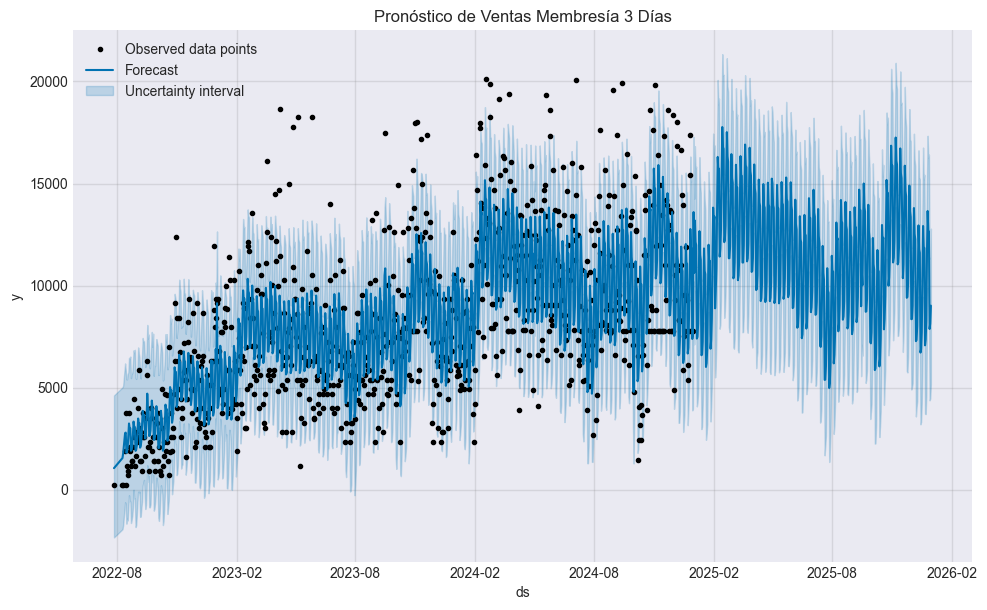

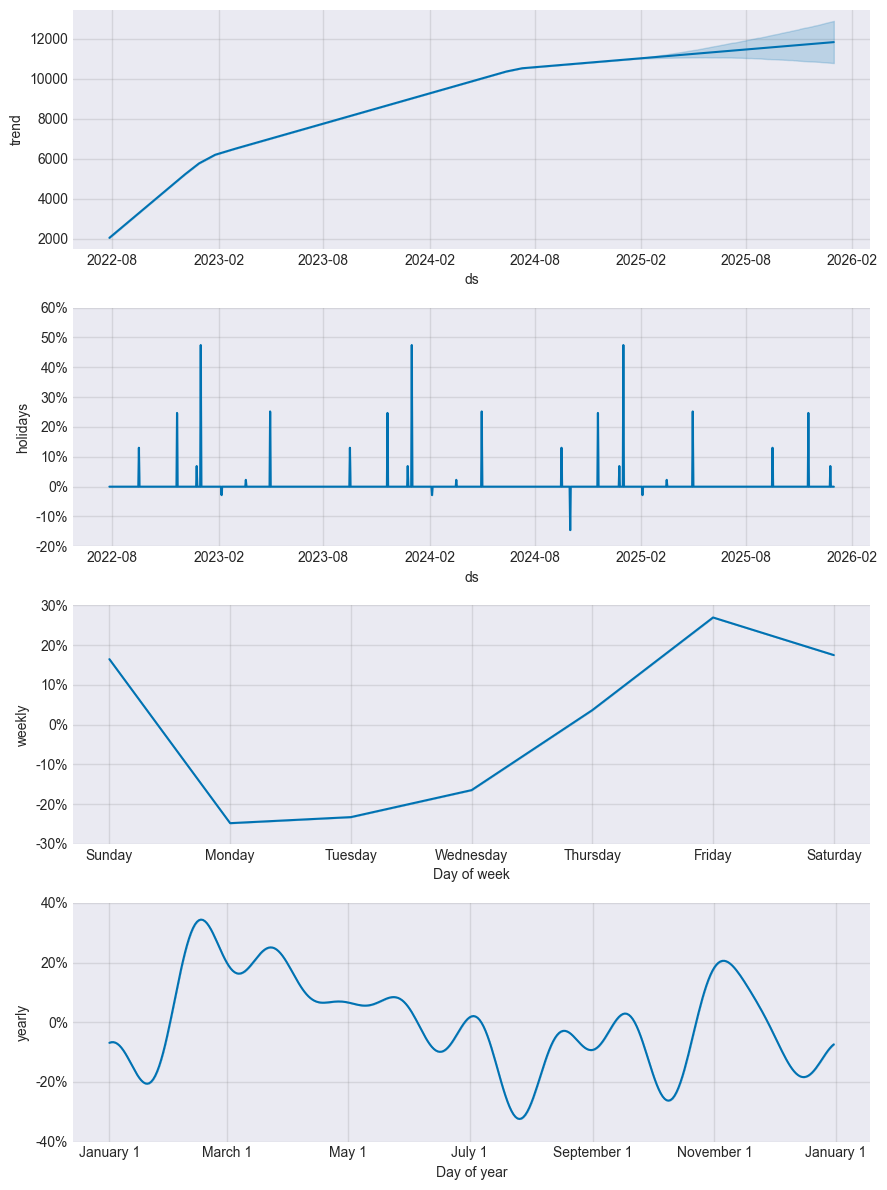

In [187]:
# 1. Gráfico principal: Puntos negros son datos reales, línea azul es la predicción
fig1 = m.plot(forecast)
plt.title("Pronóstico de Ventas Membresía 3 Días")
# mostrar leyenda
plt.legend()
plt.show()

# 2. Desglose de componentes: Muestra Tendencia, Semanal, Anual y Festivos por separado
fig2 = m.plot_components(forecast)
plt.show()

##### Agrupamos data por mes para su exportacion

In [188]:
# agrupar por mes y sumar yhat, yhat_lower, yhat_upper
forecast['ds'] = pd.to_datetime(forecast['ds'])
forecast['month'] = forecast['ds'].dt.to_period('M')
monthly_sales = forecast.groupby('month')[['yhat', 'yhat_lower', 'yhat_upper']].sum().round(2).reset_index()
print(monthly_sales)

      month       yhat  yhat_lower  yhat_upper
0   2022-07    1052.38    -2343.39     4616.63
1   2022-08   50606.68   -23016.63   123858.90
2   2022-09   93979.31    -6048.39   193768.68
3   2022-10  112324.74     4406.33   220251.51
4   2022-11  159618.32    56541.96   263524.36
5   2022-12  150685.08    43974.84   259474.21
6   2023-01  163819.94    56874.71   272659.49
7   2023-02  222338.97   124085.99   319585.00
8   2023-03  249400.36   142500.52   356100.33
9   2023-04  228471.82   124671.87   331433.51
10  2023-05  233274.35   124573.45   342951.75
11  2023-06  214051.98   109680.04   319663.34
12  2023-07  199692.19    91719.06   306684.70
13  2023-08  217247.35   109207.79   325066.31
14  2023-09  240371.92   136558.81   343625.93
15  2023-10  228436.83   121780.12   335292.61
16  2023-11  292779.44   188457.33   397142.88
17  2023-12  245776.66   138900.00   354974.09
18  2024-01  244744.83   138426.50   353000.27
19  2024-02  338477.47   238231.71   439670.39
20  2024-03  

In [189]:
monthly_sales.to_csv("../data/data_forecast_2025_gold/forecast_3_dias_2025_monthly.csv")

In [190]:
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon='90 days')

# 2. Calcular métricas de error
df_p = performance_metrics(df_cv)

# 3. Ver el resultado (Las métricas más importantes)
print(df_p[['horizon', 'rmse', 'mape']].head())

  0%|          | 0/1 [00:00<?, ?it/s]11:58:20 - cmdstanpy - INFO - Chain [1] start processing
11:58:20 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 1/1 [00:00<00:00,  2.62it/s]


  horizon         rmse      mape
0  9 days  5835.234079  1.473082
1 10 days  6499.760482  1.701168
2 11 days  7571.319324  2.229217
3 12 days  7784.645973  2.392252
4 13 days  7797.257482  2.413033
